# 6 Data Transformation - Stationarity

Considering time series data is being dealt with throughout this project, the temporal order of records must be maintained. Similarly, to allow for the prediction of raw trends and information, stationarity must occur to remove this time variant nature and allow for time invariant statistical properties. This is the role of Stationarity as attributes such as the mean, variance and autocorrelation of the time series do not change after transformation and data can be viewed in it raw, de-trended form. This notebook explores different methods for achieving stationarity for the AUD/USD dataset from 2011-2019.

In [210]:
#import libraries
import os
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re
import string
from textblob import TextBlob
import snscrape.modules.twitter as sntwitter
import datetime
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#Import K-NN Clasiffer and methods for splitting training/test data + score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from wordcloud import WordCloud, STOPWORDS

from statsmodels.tsa.stattools import adfuller

from matplotlib import pyplot as plt

import seaborn as sns

from datetime import date, timedelta
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

import talib as ta

import praw
from pushshift_py import PushshiftAPI 

import math
import json
import itertools
import requests
import time
from datetime import datetime, timedelta, timezone


## 6.1 Load Dataset

In [211]:
#read dataset in
df = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")

#index by date and remove duplicates
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

df['Date'] = pd.DataFrame(df.Date).applymap(lambda x: x.date())

df['Return'] = df.Close.pct_change()

df = df.set_index(df.Date)

df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return']]

#remove 0 volume days
df = df[df['Volume'] != 0]

#df = df[pd.Timestamp('2015-01-01'):pd.Timestamp('2018-01-01')]
df

,Open,High,Low,Close,Volume,Return
Date,,,,,,
2011-01-02,1.02070,1.02267,1.01582,1.01687,69778.4109,-0.005808
2011-01-03,1.01687,1.01716,1.00294,1.00517,124906.5397,-0.011506
2011-01-04,1.00517,1.00770,0.99613,0.99961,119343.0942,-0.005531
2011-01-05,0.99961,1.00159,0.99338,0.99449,99106.5343,-0.005122
2011-01-06,0.99448,0.99932,0.99087,0.99614,101413.4171,0.001659
...,...,...,...,...,...,...
2018-12-25,0.70428,0.70723,0.70333,0.70693,77848.7096,0.003848
2018-12-26,0.70693,0.70786,0.70173,0.70352,193196.9914,-0.004824
2018-12-27,0.70338,0.70698,0.70287,0.70412,147956.1087,0.000853


## 6.2 Testing for Stationarity

The ADF test is used to test for stationarity of a series and determine which features must be transformed.

In [212]:
#perform adf test on given feature
def adf_test(df, feature, th):
    check_stationary = adfuller(df[feature].values)
    
    adf_stat = check_stationary[0]

    p_val = check_stationary[1]

    crit_vals = check_stationary[4]
    
    print("The ADF Statistic is: ", adf_stat)
    
    print("The P-Value is: ", p_val)
    
    print("Critical Values:")
    print("================")
    for key, val in crit_vals.items():
        
        print(f'{key}: {val}')
        
    if p_val < th:
        
        print('Feature [{}] is stationary'.format(feature))
        
    else:
        
        print('Feature [{}] is not stationary'.format(feature))


In [213]:
def plot_feature(feature, name):
    
    fig,ax = plt.subplots(figsize=(15,7))
    
    ax.plot(feature.index, feature)
    
    ax.set_title(name)
    ax.set_ylabel(name)
    ax.set_xlabel("Date")

In [214]:
adf_test(df, 'Close', 0.05)

The ADF Statistic is:  -0.7757969534016922
The P-Value is:  0.8261283629532468
Critical Values:
1%: -3.4334872119603324
5%: -2.862925883058088
10%: -2.567507779564507
Feature [Close] is not stationary


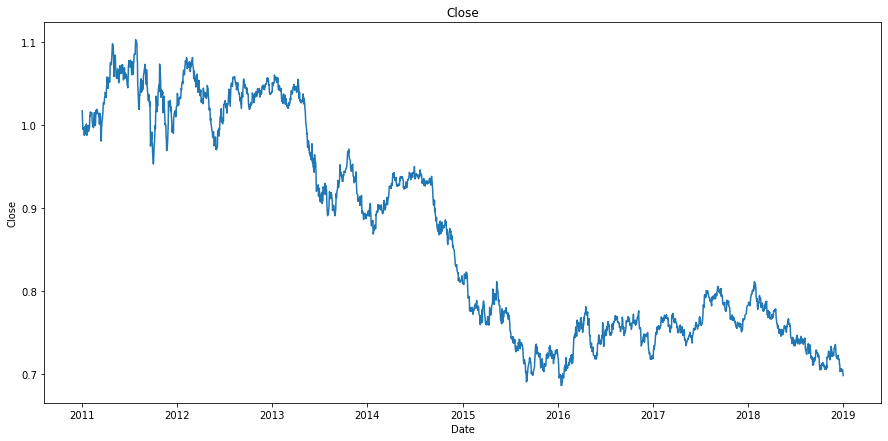

In [215]:
plot_feature(df.Close, 'Close')

In [216]:
adf_test(df, 'Return', 0.05)

The ADF Statistic is:  -47.22917766845937
The P-Value is:  0.0
Critical Values:
1%: -3.4334827032362396
5%: -2.862923892346305
10%: -2.5675067196263823
Feature [Return] is stationary


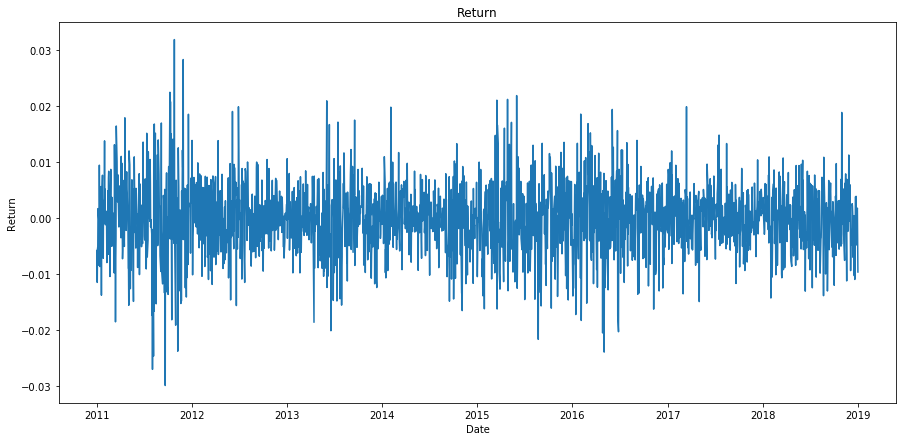

In [217]:
plot_feature(df.Return, 'Return')

## 6.3 Integer Differencing

The most fundamental method for attaining stationarity is through integer differencing. For first order integer differencing, this is simply the subtraction of the current series by the lag_1 series. This section will explore integer differencing for the AUD/USD dataset.

In [218]:
THRESH = 0.05

#function to return all columns that are not stationary
def get_non_stationary(df, threshold):
    
    non_stationary = []
        
    for column in df.columns:
        
        check_stationary = adfuller(df[column].values)

        adf_stat = check_stationary[0]

        p_val = check_stationary[1]

        crit_vals = check_stationary[4]

        if p_val < threshold:
            
            continue
            
        else:
            
            non_stationary.append(column)
            
    return non_stationary
        
#function to make non-stationary columns stationary through integer differencing (log returns)
def make_stationary(df, cols, threshold):
    
    for col in cols:
        
        df[col] = pd.DataFrame(np.log(df[col]).pct_change()).values
    
    df = df.dropna()
    
    check = get_non_stationary(df, threshold)
    
    if len(check) == 0:
        
        print("Date is now stationary!")
        
    else:
        
        print("Data still non-stationary!")
        
    return df

In [219]:
#Make data stationary using integer differencing of log values -> log returns
stationary = df.copy()

bad_columns = get_non_stationary(df, THRESH)

print("Non-stationary features:", bad_columns)

stationary = make_stationary(stationary, bad_columns, THRESH)

Non-stationary features: ['Open', 'High', 'Low', 'Close']
Date is now stationary!


In [220]:
stationary

,Open,High,Low,Close,Volume,Return
Date,,,,,,
2011-01-03,-0.183486,-0.240998,-0.812968,-0.691757,124906.5397,-0.011506
2011-01-04,-0.691757,-0.549176,-2.320818,-1.075645,119343.0942,-0.005531
2011-01-05,-1.075645,-0.792877,0.712958,13.164509,99106.5343,-0.005122
2011-01-06,13.190287,-1.428158,0.380897,-0.300036,101413.4171,0.001659
2011-01-09,0.194483,1.457100,0.272120,0.109042,118394.7046,-0.000422
...,...,...,...,...,...,...
2018-12-25,0.005860,-0.000694,0.001659,-0.010953,77848.7096,0.003848
2018-12-26,-0.010713,-0.002570,0.006471,0.013942,193196.9914,-0.004824
2018-12-27,0.014516,0.003600,-0.004583,-0.002424,147956.1087,0.000853


In [221]:
adf_test(stationary, 'Close' , 0.05)

The ADF Statistic is:  -14.837713774587153
The P-Value is:  1.8573874714849846e-27
Critical Values:
1%: -3.4334947554105537
5%: -2.862929213668854
10%: -2.567509552921939
Feature [Close] is stationary


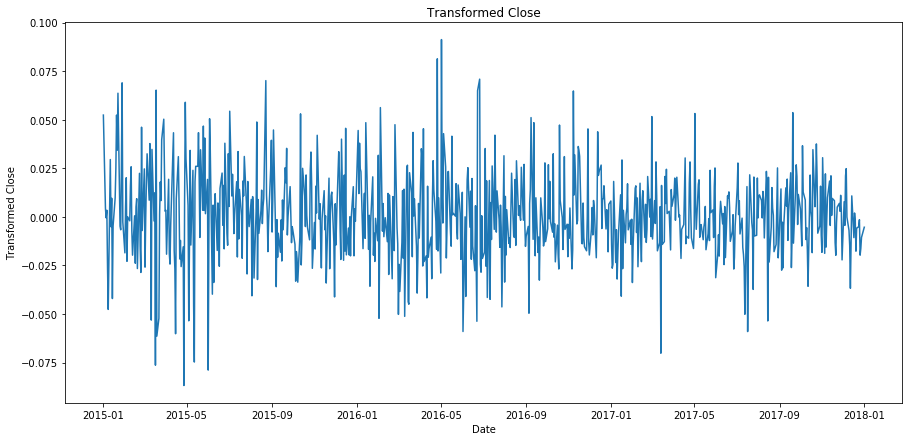

In [222]:
plot_feature(stationary.Close[pd.Timestamp('2015-01-01'):pd.Timestamp('2018-01-01')], 'Transformed Close')

## 6.4 Fractional Differencing

Fractional Differencing extends differencing to real numbers in an attempt to retain memory from the original price series whilst attaining stationarity.

In [282]:
#function to calculate weights of past values
def calc_weights(d=0.1, threshold=1e-5):
    """
    : param d: order of differencing
    : param threshold: threshold used to stop calculating derivatives
    """
    weights, k = [1.], 1
    
    while True:
        
        new_weight = -weights[-1]/k*(d-k+1)
        
        if abs(new_weight)<threshold:
        
            break
            
        weights.append(new_weight)
        
        k += 1
        
    weight_list = np.array(weights[::-1])
    weights_reshaped = weight_list.reshape(-1,1)
    
    return weights_reshaped

def fractional_differencing(dataframe, d=0.1, threshold=1e-4):
    """
    : param dataframe: price series
    : param d: order of differencing
    : param threshold: threshold used to stop calculating derivatives
    """
    stationary_data = pd.DataFrame()
    
    for col in dataframe.columns:
                
        feature = dataframe[col]
    
        weights = calc_weights(d,threshold)

        num_weights = len(weights) - 1

        df = pd.Series(dtype=float)
        #widow size can't be larger than the size of data
        if num_weights >= feature.shape[0]:
            
            print("width too big")
            return
        
        else:

            for i in range(num_weights, feature.shape[0]):

                i_0_index, i_1_index = feature.index[i-num_weights], feature.index[i]

                data = np.dot(weights.T, feature.loc[i_0_index:i_1_index])[0]

                df[i_1_index] = data

            stationary_data[col] = df
                   
    return stationary_data

#Function to plot adf test and correlation of series after differencing to help tune value for d
def adf_test_orders(df, threshold):
    
    statistics = pd.DataFrame(columns=['adfStat','pVal','lags','N','5% Crit Val','Corr w/ OG'])
    
    for d in np.linspace(0, 1 , 11):
        
        price_trans = fractional_differencing(pd.DataFrame(np.log(df['Close'])), d=d, threshold=threshold)
        
        corr = price_corr_np = np.corrcoef(df['Close'].loc[price_trans.Close.index], price_trans.Close)[0,1] 
        
        adf_results = adfuller(price_trans.Close, maxlag=1, regression='c',autolag=None)
        
        statistics.loc[d] = list(adf_results[:4]) + [adf_results[4]['5%']] + [corr] 
        
    return out

def trans_a_bunch_of_data_FFD(df, d=0.1, th=1e-4):
    a_bunch_of_trans_data = pd.DataFrame()
    
    for col in df.columns:
        trans_data = transfer_data_by_frac_diff_FFD(df[col], \
                     d=d, th=th)
        a_bunch_of_trans_data[col] = trans_data
    
    return a_bunch_of_trans_data

In [286]:
stationarize = df.copy()

stationary_fd = fractional_differencing(stationarize, 0.4, 1e-4)

print("Number of observations lost:", df.shape[0] - stationary_fd.shape[0])

stationary_fd.shape, df.shape

Number of observations lost: 281


((1810, 6), (2091, 6))

In [289]:
stationary_fd

,Open,High,Low,Close,Volume,Return
2012-01-18,0.084680,0.078396,0.081488,0.079583,24409.598782,-0.004788
2012-01-19,0.079786,0.083233,0.081068,0.085577,-2315.070295,0.005732
2012-01-22,0.085125,0.089025,0.087337,0.086307,-7531.957776,0.000661
2012-01-23,0.086693,0.081106,0.080472,0.080501,18491.989680,-0.005547
2012-01-24,0.080611,0.089149,0.081902,0.090759,42392.794274,0.009753
...,...,...,...,...,...,...
2018-12-25,0.041634,0.042718,0.043254,0.045468,176.619606,0.005553
2018-12-26,0.045426,0.043976,0.042251,0.041590,104007.919686,-0.005506
2018-12-27,0.041422,0.043325,0.044424,0.043668,13348.835086,0.002931
2018-12-30,0.044082,0.044210,0.044937,0.045229,-20491.713628,0.002202


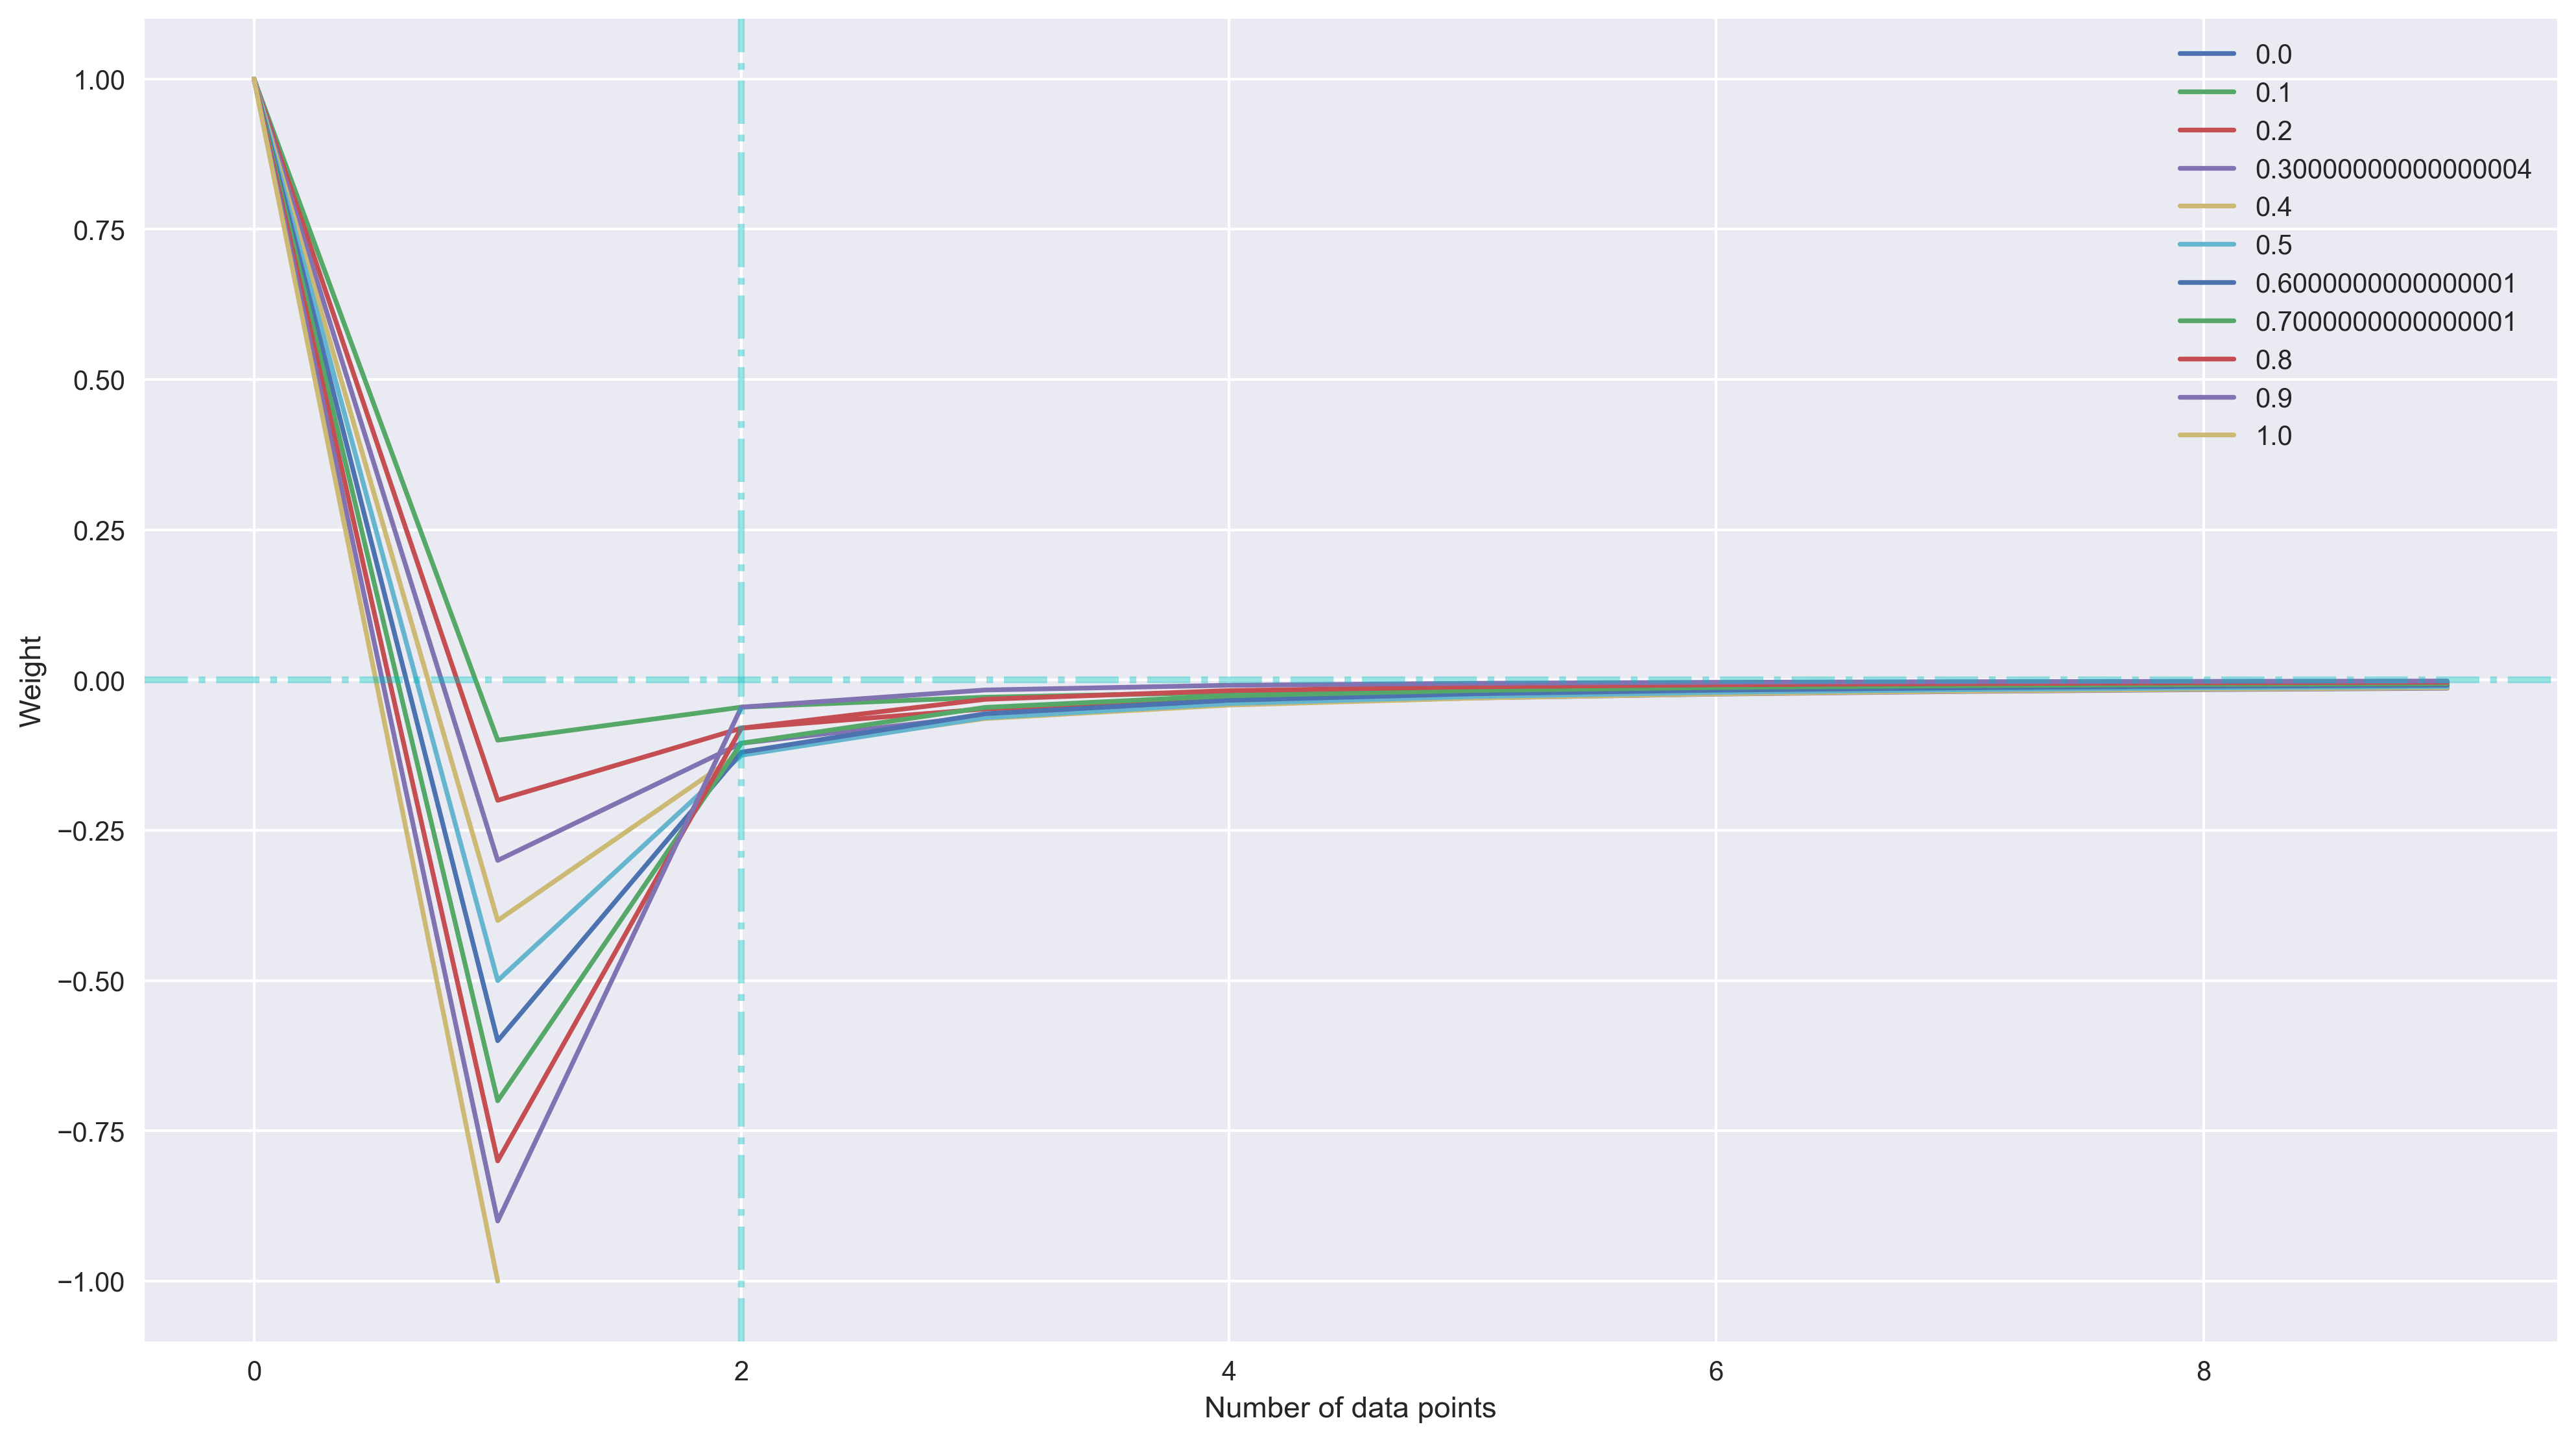

In [328]:
plotWeights(weights[:10]);

In [288]:
orders = adf_test_orders(df.copy(), 1e-3)

orders

,adfStat,pVal,lags,N,5% Crit Val,Corr w/ OG
0.0,-0.754356,8.321634e-01,1.0,2089.0,-2.862925,0.998977
0.1,-2.246373,1.898471e-01,1.0,1587.0,-2.863363,0.984931
0.2,-3.279014,1.584299e-02,1.0,1593.0,-2.863356,0.927686
0.3,-4.924573,3.123027e-05,1.0,1702.0,-2.863240,0.861849
0.4,-7.629806,2.022950e-11,1.0,1808.0,-2.863140,0.765292
0.5,-11.477998,5.075226e-21,1.0,1890.0,-2.863070,0.627107
0.6,-15.793166,1.096072e-28,1.0,1950.0,-2.863023,0.457699
0.7,-20.197876,0.000000e+00,1.0,1993.0,-2.862991,0.319069
0.8,-24.324067,0.000000e+00,1.0,2026.0,-2.862968,0.217168
0.9,-28.294123,0.000000e+00,1.0,2052.0,-2.862950,0.125751


In [287]:
adf_test(stationary_fd, 'Close' , 0.05)

The ADF Statistic is:  -3.5482495115099075
The P-Value is:  0.006831039736975423
Critical Values:
1%: -3.4340044039750235
5%: -2.863154216066867
10%: -2.5676293568762953
Feature [Close] is stationary


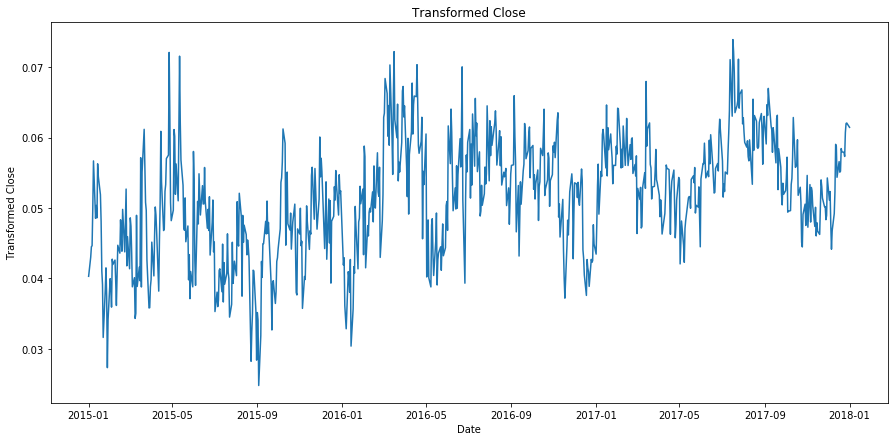

In [290]:
plot_feature(stationary_fd.Close[pd.Timestamp('2015-01-01'):pd.Timestamp('2018-01-01')], 'Transformed Close')

## 6.5 Test Transformed Data on KNN-Classifier

In [296]:
data = df.copy()

#get labels
def get_labels(data):
    
    #get barriers and returns
    fhm_labels = pd.DataFrame(data.Return.shift(-1)).applymap(lambda x: 1 if x > 0 else - 1)

    labels = fhm_labels
    
    #make indexing for price data the same as the generated labels
    joined = pd.concat([data, labels], axis=1)

    joined.dropna(inplace=True)
    
    joined.columns = ['Open','High','Low','Close','Volume','Return','Label']
    
    return joined

def knn_model(data, labels, method):
    #generate training data and split
    X = data.copy().drop(columns=['Label'])
    y = labels.values.astype(int)
    
    split = int(len(X)*0.7)

    X_train = X[0:split]
    X_test = X[split+1:]
    
    y_train = y[0:split]
    y_test = y[split+1:]

    knn = KNeighborsClassifier()
    knn.fit(X_train,y_train)
    predicted = knn.predict(X_test)

    score = cross_val_score(knn,X_train,y_train)
    
    print("The cross validation score of the " + method + " is", knn.score(X_test,y_test))
    
    #Plot confusion matrices
    titles_options = [("Confusion matrix, without normalization", None)]

    disp = plot_confusion_matrix(knn, X_test, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues)

    disp.ax_.set_title("Confusion Matrix")
    
    return score

The cross validation score of the Integer Differenced Data is 0.5239616613418531


array([0.51194539, 0.51877133, 0.46075085, 0.51369863, 0.50684932])

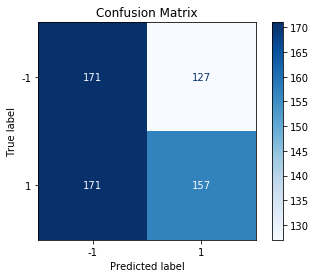

In [297]:
integer_diff_data = get_labels(stationary)
knn_model(integer_diff_data, integer_diff_data.Label, 'Integer Differenced Data')

The cross validation score of the Fractionally Differenced Data is 0.46863468634686345


array([0.47244094, 0.51181102, 0.50592885, 0.52173913, 0.48221344])

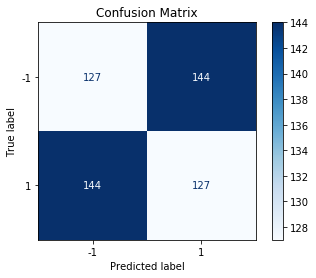

In [300]:
frac_diff_data = get_labels(stationary_fd)
knn_model(frac_diff_data, frac_diff_data.Label, 'Fractionally Differenced Data')

No real performance difference can be observed from leveraging fractional differencing despite its memory capabilities. Moreover, as fractional differencing results in a loss of data due to the calculation of previous lag weights, the integer differencing method for stationarity will be used going forward.